# Источник данных

Источник данных: Johns Hopkins CSSE. Исходные данные доступны в [этом репозитории](https://github.com/CSSEGISandData/COVID-19).

Предобработанный одним из кэгглеров датасет и различные варианты прогнозов и визуализация [доступны на платформе Kaggle](https://www.kaggle.com/imdevskp/corona-virus-report). 

Этот ноутбук создан для моих русскоязычных друзей, проживающих в России.

In [1]:
from datetime import datetime
print('Дата обновления этого ноутбука:')
print(datetime.today())

Дата обновления этого ноутбука:
2020-03-22 11:30:44.850778


In [2]:
import pandas as pd
import wget

urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv']

for url in urls:
    filename = wget.download(url)

In [3]:
def select_russian_data(data, column_name):
    df = data.copy()
    df = df[df['Country/Region']=='Russia'].reset_index()
    df.drop(columns=['index', 'Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True)
    return df.T.rename(columns={0: column_name})

cases = select_russian_data(pd.read_csv('time_series_19-covid-Confirmed.csv'), 'cases')
deaths = select_russian_data(pd.read_csv('time_series_19-covid-Deaths.csv'), 'deaths')
recovered = select_russian_data(pd.read_csv('time_series_19-covid-Recovered.csv'), 'recovered')

russian_data = cases.merge(deaths, left_index=True, 
                           right_index=True).merge(recovered, left_index=True, right_index=True)

russian_data.index = pd.to_datetime(russian_data.index)

In [4]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates

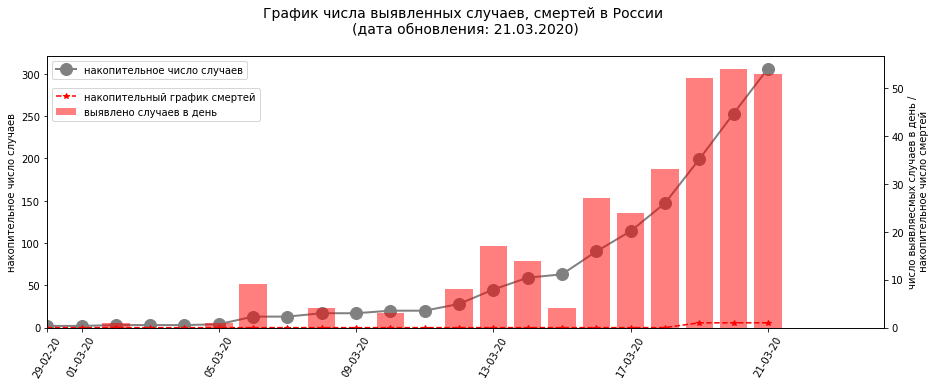

In [5]:
log = False # set True for log scale

start_date = pd.to_datetime('29-02-2020') 
    
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(russian_data['cases'], color='grey', marker='o', linewidth=2, markersize=12)
if log == True: ax1.set_yscale('log')
    
ax2 = ax1.twinx()
ax2.plot(russian_data['deaths'], color='red', marker='*', linestyle='--')

cases_a_day = russian_data['cases'] - russian_data['cases'].shift(1).fillna(0)
ax2.bar(x=cases_a_day.index, height=cases_a_day, color='red', alpha=0.5)

if log == True: ax2.set_yscale('log')

title = '''График числа выявленных случаев, смертей в России {}
(дата обновления: {:%d.%m.%Y})
'''.format(''.join(['(логарифмическая шкала)' if log else '']), cases_a_day.index.max())

ax1.set_xlim(start_date)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax1.set_ylim(0)
plt.title(title, fontsize=14)
ax1.legend(['накопительное число случаев'])
ax2.legend([ 'накопительный график смертей', 'выявлено случаев в день'], 
               loc='upper left', bbox_to_anchor=(0, 0.1, 0.5, 0.8))

ax1.set_ylabel('накопительное число случаев')
ax2.set_ylabel('число выявляесмых случаев в день /\n накопительное число смертей')
plt.show()